# CelebA WGAN-GP
Get the CelebA dataset [here](hhttps://mmlab.ie.cuhk.edu.hk/projects/CelebA.html). 

In [1]:
# imports
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch
from torch import autograd
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


## Load images into a dataset 


In [3]:
transform = transforms.Compose([transforms.Resize([64, 64]),
                                # scale between [0, 1]
                                transforms.ToTensor(), 
                                # subtract by 0.5, divide by 0.5, to get range [-1, 1] for tanh activation
                                transforms.Normalize(mean=0.5, std=0.5)])
dataset = datasets.ImageFolder('data/celeba/', transform=transform)

In [5]:
pinmem = False
if device == "cuda":
    pinmem = True
dataloader = torch.utils.data.DataLoader(dataset, batch_size=512, shuffle=True, num_workers=4, pin_memory=pinmem)

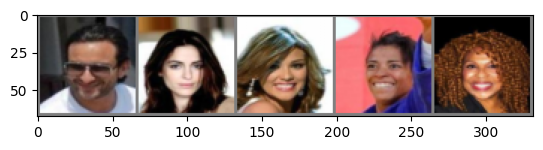

In [6]:
# Helper function for inline image display
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

images, labels = next(iter(dataloader))
img_grid = torchvision.utils.make_grid(images[:5])
matplotlib_imshow(img_grid)

## Build the Discriminator & Generator
note the DCGAN paper uses strided convolution rather than pooling to downsample saying it lets the network learn its own pooling function.

In [7]:
class Critic(nn.Module):
    def __init__(self):
        super(Critic, self).__init__()
        self.main = nn.Sequential(
            # 64x64 -> 32x32 
            # note we have bias here because w/o batch norm, the bias is no longer normalized out
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=4, stride=2, padding=1, bias=True),
            nn.LeakyReLU(0.2),
            # 32x32 -> 16x16
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=4, stride=2, padding=1), 
            nn.LeakyReLU(0.2),
            nn.Dropout2d(0.3),
            # 16x16 -> 8x8
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.Dropout2d(0.3),
            # 8x8 -> 4x4
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.Dropout2d(0.3),
            # 4x4 -> 1x1
            nn.Conv2d(in_channels=512, out_channels=1, kernel_size=4, stride=1, padding=0), 
            # no sigmoid! scores are not bounded in a WGAN
            nn.Flatten()
        )  
    
    def forward(self, x):
        return self.main(x)

In [8]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            # 1x1x128 -> 4x4x512
            nn.ConvTranspose2d(128, 512, kernel_size=4, stride=1, bias=False), 
            nn.BatchNorm2d(512, momentum=0.9),
            nn.LeakyReLU(0.2),
            # 4x4 -> 8x8
            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256, momentum=0.9),
            nn.LeakyReLU(0.2),
            # 8x8 -> 16x16
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128, momentum=0.9),
            nn.LeakyReLU(0.2),
            # 16x16 -> 32x32
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64, momentum=0.9),
            nn.LeakyReLU(0.2),
            # 32x32 -> 64x64
            nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
            # tanh for stronger gradients
            nn.Tanh(),
        )  
    
    def forward(self, x):
        # add 2 dims to noise tensor with 128 params so we can use conv
        x = torch.reshape(x, (-1, 128, 1, 1)) # b, c, h, w
        return self.main(x)

## Training

In [9]:
critic = Critic().to(device)
generator = Generator().to(device)

# individual optimizers for discrimination and generation
c_optim = torch.optim.Adam(critic.parameters(), lr=0.0002, betas=(0.5, 0.999)) # specified in the DCGAN paper
g_optim = torch.optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))

# labels for the discriminator
REAL, FAKE = 1., 0.

# batch size 512, 128 noise
test_noise = torch.randn([512, 128]).to(device)

# update critic multiple times per generator update
critic_reps = 3

epochs = 5
gp_weight = 10.

In [17]:
def gradient_penalty(batch_size, real_images, fake_images):
    #alpha = torch.randn([batch_size, 1, 1, 1]) # typo in textbook?
    alpha = torch.rand(batch_size, 1, 1, 1).to(device) 
    # alpha = alpha.expand_as(real_images) # why not in textbook?
    
    diff = fake_images - real_images
    # each image in interpolated is some random amt in between reall and fake
    interpolated = real_images + alpha * diff 
    # run critic on interpolated
    pred = critic(interpolated)
    # calculate gradients w.r.t. interpolated
    gradients = autograd.grad(outputs=pred, inputs=interpolated,
                               grad_outputs=torch.ones(pred.size()).to(device), # what is grad_outputs?
                               create_graph=True, retain_graph=True)[0]
    # print(gradients.shape) -> [512, 3, 64, 64]
    # calculate l2 norm of gradients
    gradients = gradients.view(gradients.size(0), -1) # flatten
    l2_norm = torch.linalg.norm(gradients, dim=1, ord=2)  # l2
        #l2_norm = torch.sqrt(torch.sum(gradients ** 2, dim=(1, 2, 3)))
    # gradient penalty is avg squared distance between l2 and 1
    gp = ((l2_norm - 1.) ** 2).mean()
    return gp

[0/5] Batch 390/396 c_loss:-6.7529 g_loss:14.6820 avg_fake_pred: -14.6820 avg_real_pred: -2.3085 c_gp: 0.0926274752


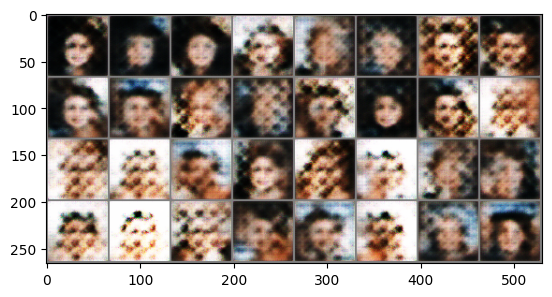

[1/5] Batch 390/396 c_loss:-8.2220 g_loss:-6.8753 avg_fake_pred: 6.8753 avg_real_pred: 17.4588 c_gp: 0.0637107


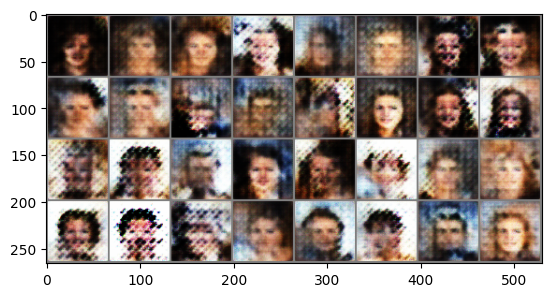

[2/5] Batch 390/396 c_loss:-0.7497 g_loss:-24.4279 avg_fake_pred: 24.4279 avg_real_pred: 28.3420 c_gp: 0.03950


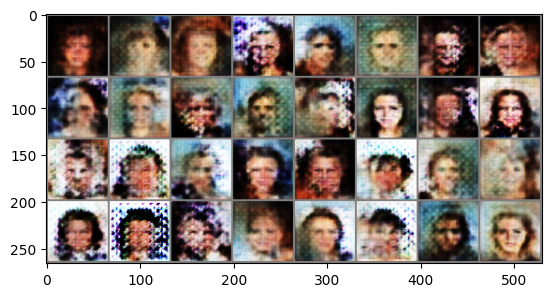

[3/5] Batch 390/396 c_loss:-1.8289 g_loss:-71.9873 avg_fake_pred: 71.9873 avg_real_pred: 74.5748 c_gp: 0.087955


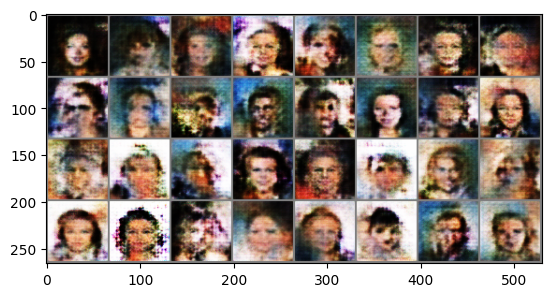

[4/5] Batch 390/396 c_loss:-8.3151 g_loss:-119.1041 avg_fake_pred: 119.1041 avg_real_pred: 125.4531 c_gp: 0.0640


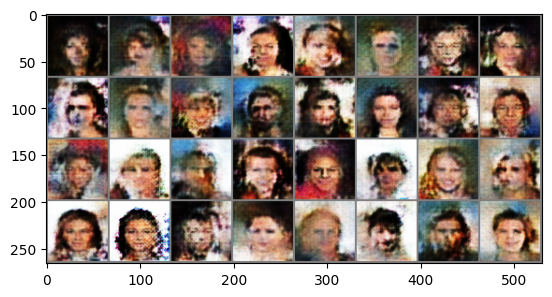

In [18]:
# 10 mins per epoch?
for epoch in range(epochs):
    for batch_num, (real_images, _) in enumerate(dataloader, start=0):
        real_images = real_images.to(device)
        batch_size = real_images.shape[0]

        ### train critic multiple times per generator train
        for rep in range(critic_reps):
            real_pred = critic(real_images)
            noise = torch.randn([batch_size, 128]).to(device)
            fake_images = generator(noise)
            fake_pred = critic(fake_images)
            c_wass_loss = torch.mean(fake_pred) - torch.mean(real_pred)
            c_gp = gradient_penalty(batch_size, real_images, fake_images)

            c_loss = c_wass_loss + c_gp * gp_weight
            c_optim.zero_grad()
            c_loss.backward()
            c_optim.step()
        
        ### train generator 
        noise = torch.randn([batch_size, 128]).to(device)
        fake_images = generator(noise) # rerunning after discriminator is updated
        fake_pred = critic(fake_images)
        g_wass_loss = -torch.mean(fake_pred)
        g_optim.zero_grad()
        g_wass_loss.backward()
        g_optim.step()
        
        
        avg_fake_pred = -g_wass_loss
        avg_real_pred = torch.mean(real_pred)
        
        if batch_num % 10 == 0:
            print(f"\r[{epoch}/{epochs}] Batch {batch_num}/{len(dataloader)} c_loss:{c_loss.item():.4f} g_loss:{g_wass_loss.item():.4f} ", end='')
            print(f"avg_fake_pred: {avg_fake_pred:.4f} avg_real_pred: {avg_real_pred:.4f} ", end="")
            print(f"c_gp: {c_gp:.4f}", end="")

    print("")
    images = generator(test_noise)
    img_grid = torchvision.utils.make_grid(images[:32].to('cpu'))
    matplotlib_imshow(img_grid)
    plt.show()
    save_path = f"wgan_generator_ep{epoch}"
    torch.save(generator.state_dict(), save_path)
    save_path = f"wgan_critic_ep{epoch}"
    torch.save(critic.state_dict(), save_path)

## Visual Evaluation

In [9]:
checkpoint = torch.load("wgan_generator_ep4", map_location=device)
generator.load_state_dict(checkpoint)

<All keys matched successfully>

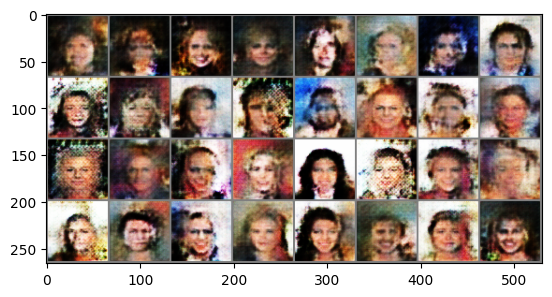

In [19]:
images = generator(torch.randn([batch_size, 128]).to(device))
img_grid = torchvision.utils.make_grid(images[:32].to('cpu'))
matplotlib_imshow(img_grid)